# Bechdel Test using AI

## Overview
The purpose of this notebook is to investigate, compare, and combine methodologies in order to determine whether a movie passes the Bechdel Test using its script and metadata gathered from various APIs. 

![The Bechdel test is credited to Liz Wallace as well as the writings of Virginia Woolf, and was first publicized in this 1985 comic strip by Alison Bechdel.](https://upload.wikimedia.org/wikipedia/en/b/bf/Dykes_to_Watch_Out_For_%28Bechdel_test_origin%29.jpg) 

The test, used to measure women's representation in film and other fiction, requires two female characters to have a conversation about something other than a male character in order to 'pass' the test. ([Wikipedia](https://en.wikipedia.org/wiki/Bechdel_test)) 

It's worth noting that while the Bechdel Test can be a good way to survey the media landscape, it certainly doesn't tell the whole story of gender representation, especially on a film-by-film basis. A conversation can include or be about men and also represent real, complex female characters, while a short, throwaway scene having no effect on the plot can be enough to 'pass' the test. This is important because a model is only as good as its data. 

In other words, **no model trained to classify movie scripts, using Bechdel Test ratings as targets, can provide more insight on gender representation in media than the Bechdel Test itself.**

## Data: Targets

This first set of data comes from the [Bechdel Test Movie List](https://bechdeltest.com/), via the [API](https://bechdeltest.com/api/v1/doc). The API documentation asks that the 'getAllMovies' method be used sparingly, which is why the following code is commented out, but it can be used to recreate the csv file imported below. 

Creating a dataset of movie scripts will prove much more difficult than a single API call, and manually labeling data by watching movies (or reading their scripts) would be prohibitively time consuming. **Therefore, the best approach to creating a full, labeled dataset for this project is to begin with this labeled Bechdel Test data, and then attempt to find and attach a script for as many records as possible.**

In [1]:
from urllib.error import HTTPError
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import numpy as np
import os
import json
import requests
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from urllib.request import urlopen
import html2text
import math
import re
import ast
warnings.filterwarnings("ignore")

In [2]:
'''
r = requests.get('http://bechdeltest.com/api/v1/getAllMovies')
d = r.text
d = json.loads(d)
id, imdbid, rating, title, year = [], [], [], [], []
for i in data:
    id.append(i['id'])
    imdbid.append(i['imdbid'])
    rating.append(i['rating'])
    title.append(i['title'])
    year.append(i['year'])
df = pd.DataFrame({'id':id, 'imdbid':imdbid, 'title':title, 'rating':rating, 'year':year})  
df.to_csv('BechdelData.csv')   
'''


"\nr = requests.get('http://bechdeltest.com/api/v1/getAllMovies')\nd = r.text\nd = json.loads(d)\nid, imdbid, rating, title, year = [], [], [], [], []\nfor i in data:\n    id.append(i['id'])\n    imdbid.append(i['imdbid'])\n    rating.append(i['rating'])\n    title.append(i['title'])\n    year.append(i['year'])\ndf = pd.DataFrame({'id':id, 'imdbid':imdbid, 'title':title, 'rating':rating, 'year':year})  \ndf.to_csv('BechdelData.csv')   \n"

In [3]:
targets = pd.read_csv('BechdelData.csv').drop(columns='Unnamed: 0')

The first movie listed as passing the Bechdel test is [Cendrillon,](https://en.wikipedia.org/wiki/Cinderella_(1899_film), which is French for Cinderella. The full film is available on [wikipedia](https://en.wikipedia.org/wiki/Cinderella_(1899_film))- it has no script or words and I'm not sure that the Bechdel Test even really applies. However, it's only a few minutes long, and in 1899 when it was released, it's special effects and production were considered to be state-of-the-art.

In [4]:
targets.loc[83:87]

id    imdbid                              title  rating  year
83  5411  224240.0     Temptation of St. Anthony, The       0  1898
84  4994     246.0  A Turn of the Century Illusionist       0  1899
85  5914     230.0                         Cinderella       3  1899
86  1594  291476.0            Sherlock Holmes Baffled       0  1900
87  4271     300.0             Enchanted Drawing, The       0  1900

For each movie or TV show in the dataset, the data contains an ID from the API, an ID from IMDb, the movie's title, the year it was released, and most importantly, the rating. The ratings go by the original comic- from the [Bechdel Test Movie List](https://bechdeltest.com/), via the [API](https://bechdeltest.com/api/v1/doc) website, they are assigned as follows:
1. It has to have at least two (named) women in it
2. Who talk to each other
3. About something besides a man.
(Otherwise, it earns a 0.)

A couple attributes are left out when querying the entire dataset that are available when querying by imdb id or title, notably including a boolean 'dubious' column, representing whether a movie's rating is, well, dubious. This data could definitely be useful in fine-tuning a model, so it's worth referring back to later with a narrower set of movies on which to query for more information (rather than making 10,000 requests right off the bat.)

In [5]:
r = requests.get('http://bechdeltest.com/api/v1/getMovieByImdbId?imdbid=0000230')
pd.Series(json.loads(r.text))

visible                          1
imdbid                     0000230
rating                           3
dubious                          0
title                   Cinderella
submitterid                  11200
date           2014-11-12 06:46:54
id                            5914
year                          1899
dtype: object

Grouping the data by decade, there appear to be roughly as many movies passing as failing the test going as far back as 1930, with movies that pass the test gaining a slight edge in the mid 1980s. The yellow line represents 1985, the year Alison Bechdel originally published her comic strip.

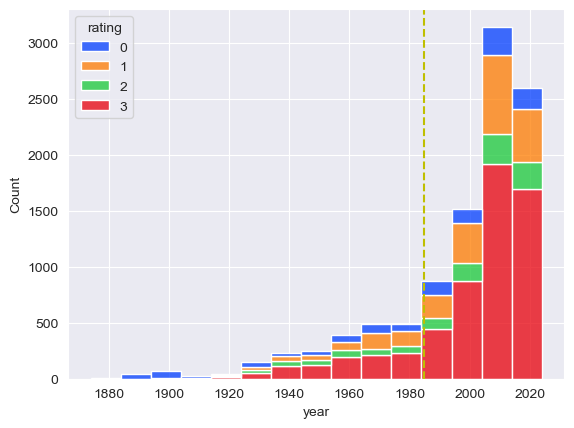

In [6]:
plot = sns.histplot(data=targets, x='year', hue='rating', multiple='stack', binwidth=10, palette='bright')
plot.axvline(x=1985, color='y', linestyle='--')

Of the 10,286 rows in the data, 57% pass the Bechdel test, with the remaining 43% divided between the other categories. Though the main goal of this project is to create a binary classifier, these more 'granular' ratings may be very useful in determining where a process is going wrong, especially when involving generative AI. Moreover, they can be used as targets for various models as part of a larger ensemble approach.

In [7]:
df = pd.DataFrame(targets.groupby('rating')['id'].count())
df['percentage'] = round((df['id'] / sum(df['id']) * 100), 2)
df.rename(columns={'id':'count'}, inplace=True)
df

count  percentage
rating                   
0        1130       10.99
1        2223       21.61
2        1063       10.33
3        5870       57.07

## Data: Scripts
The first dataset of movie scripts comes from Aveek Saha's [Movie Script Database](https://github.com/Aveek-Saha/Movie-Script-Database). The github repository for that project features a very comprehensive [readme](https://github.com/Aveek-Saha/Movie-Script-Database?tab=readme-ov-file) file with information on how to recreate the data. It runs into a few of errors on my machine- many movie scripts are no longer available at the given link, for example, and of the 3500+ unprocessed scripts downloaded by the first python script, only 229 are fully parsed by the end of the process.

The IMDb API on which this program is built has apparently been deprecated, so the movies are only labeled with the TMDb ID (and only in some cases). Those IDs can be found in the metadata, and conveniently, TMDb's API has a 'Find By ID' method that can be used to return movies based on an external ID such as an IMDb ID. Using this method, TMDb IDs can be appended to the target dataset as the first step in linking movie scripts to those labeled targets. This method will also return some more metadata about the movie.

For the next bit of code to work, Saha's Movie Script Database must be in the same folder as this notebook. The code is commented out because it cannot be linked programatically to the records in the Bechdel dataset. While this makes it a less appealing choice for an exploratory dataset, it may yet prove useful, especially by potentially leveraging LLMs. 

In [8]:
'''
filenames = os.listdir('.\Movie-Script-Database\scripts\parsed\\dialogue')
scripts = []
for f in filenames:
    scripts.append(open('.\Movie-Script-Database\scripts\parsed\\dialogue\\' + f).read())
df = pd.DataFrame({'script': scripts, 'filename': filenames})
'''

In [9]:
'''
ls = []
for i in df['filename']:
    i = i.split('_')[0]
    ls.append(i)
df['filename'] = ls
'''

In [10]:
'''
f = open('.\Movie-Script-Database\scripts\metadata\clean_files_meta.json')
data = json.load(f)
'''

### Scraping from IMSDb
In order to create an exploratory dataset, this script will scrape scripts from [IMSDb](https://imsdb.com/) by using the title of the film and matching it with the IMSDb url format. The first 1000 records run in 4-5 minutes on my machine, so it should take slightly less than an hour to get through the whole dataset.

This script uses a very broad try-except statement, leaving only 18 out of the first 1000 records when processed. 200 records will be enough for an exploratory dataset, but if scraping other websites doesn't yield better results IMSDb can definitely be revisited with a move intensive approach.

In [11]:
'''
titles  = []
scripts = []
url = 'https://imsdb.com/scripts/asd.html'
x = urlopen(url)
notFound = x.read()
for i in targets['title']:
    i = i.replace(' ', '-')
    url = 'https://imsdb.com/scripts/' + i + '.html'
    try: 
        page = urlopen(url)
        html_bytes = page.read()
        if html_bytes == notFound:
            continue
        else:
            html = html_bytes.decode('utf-8')
            scripts.append(html)
            titles.append(i)
        
    except (HTTPError, UnicodeDecodeError): 
        continue
'''

"\ntitles  = []\nscripts = []\nurl = 'https://imsdb.com/scripts/asd.html'\nx = urlopen(url)\nnotFound = x.read()\nfor i in targets['title']:\n    i = i.replace(' ', '-')\n    url = 'https://imsdb.com/scripts/' + i + '.html'\n    try: \n        page = urlopen(url)\n        html_bytes = page.read()\n        if html_bytes == notFound:\n            continue\n        else:\n            html = html_bytes.decode('utf-8')\n            scripts.append(html)\n            titles.append(i)\n        \n    except (HTTPError, UnicodeDecodeError): \n        continue\n"

In [12]:
'''
df = pd.DataFrame({'title': titles, 'script': scripts})
df.to_csv('save.csv')
'''

"\ndf = pd.DataFrame({'title': titles, 'script': scripts})\ndf.to_csv('save.csv')\n"

In [13]:

df = pd.read_csv('save.csv')

The actual scripts are tagged with pre and /pre- this will return the raw HTML for the script itself. IndexErrors occur when there is nothing between the pre tags- these webpages usually have no script.

In [15]:
scripts = []
for sc in df['script']:
    try:
        sc = sc.split('<pre>')[1].split('</pre>')[0]
    except IndexError:
        sc = np.nan
    scripts.append(sc)
df['script'] = scripts

AttributeError: 'float' object has no attribute 'split'

In [16]:
df

Unnamed: 0                title  \
0             0                   It   
1             1         Frankenstein   
2             2          Grand-Hotel   
3             3             Scarface   
4             4    Wizard-of-Oz,-The   
..          ...                  ...   
536         536                Mulan   
537         537                 Dune   
538         538               Scream   
539         539               Willow   
540         540  Little-Mermaid,-The   

                                                script  
0    \r\n\r\n\r\n<b>                               ...  
1                                                       
2    \r\n\r\n\r\n<b>                               ...  
3    #00766\r\n\r\n\r\n\r\n\r\n         "Enjoy your...  
4    FADE IN -- Title:\r\n\r\nFor nearly forty year...  
..                                                 ...  
536  Disney's Mulan\r\nCompiled by Barry Adams <bja...  
537                                      DUNE\r\n\r...  
538                                  \r\n<b>       ...  
539  <html>\r\n<head>\r\n<script>\r\n<b><!--\r\n</b...  
540          THE LITTLE MERMAID\r\n<b>      -------...  

[541 rows x 3 columns]

This converts the HTML to Markdown:

In [17]:
x = html2text.html2text(df['script'][10])

And this prints a nice, user-friendly version of the Markdown script:

In [18]:
'''
from IPython.display import display, Markdown
display(Markdown(df['script'][10]))
'''

"\nfrom IPython.display import display, Markdown\ndisplay(Markdown(df['script'][10]))\n"

### Multi-threading
The code above can be sped up a little bit with multi-threading. This code runs in just over 7 minutes:

In [19]:
def scrape_imsdb(title, notFound=urlopen('https://imsdb.com/scripts/asd.html').read()):
    t = title.replace(' ', '-')
    url = 'https://imsdb.com/scripts/' + t + '.html'
    try: 
        page = urlopen(url)
        html_bytes = page.read()
        if html_bytes == notFound:
            tup = (title, np.nan)
        else:
            html = html_bytes.decode('utf-8')
            tup = (title, html)
    except (HTTPError, UnicodeDecodeError, IndexError):
        tup = (title, np.nan)
    finally:
        return tup
    

In [20]:
'''
processes = []
with ThreadPoolExecutor(max_workers=10) as executor:
    for title in targets['title']:
        processes.append(executor.submit(scrape_imsdb, title))


dict = {}
for task in processes:
    dict[task.result()[0]] =  task.result()[1]
'''

"\nprocesses = []\nwith ThreadPoolExecutor(max_workers=10) as executor:\n    for title in targets['title']:\n        processes.append(executor.submit(scrape_imsdb, title))\n\n\ndict = {}\nfor task in processes:\n    dict[task.result()[0]] =  task.result()[1]\n"

In [326]:
'''
scripts = pd.DataFrame.from_dict(dict, orient='index')
scripts.to_csv('scraped_imsdb_scripts.csv')
'''
scripts = pd.read_csv('scraped_imsdb_scripts.csv', index_col=0)

In [327]:
data = targets.join(scripts, on='title').rename(columns={'0': 'html'})

In [328]:
data['html'].value_counts()

html
<html>\r\n<head>\r\n<!-- Google tag (gtag.js) -->\r\n<script async src="https://www.googletagmanager.com/gtag/js?id=G-W5BXG8HCH3"></script>\r\n<script>\r\n  window.dataLayer = window.dataLayer || [];\r\n  function gtag(){dataLayer.push(arguments);}\r\n  gtag('js', new Date());\r\n\r\n  gtag('config', 'G-W5BXG8HCH3');\r\n</script>\r\n\r\n<meta name="viewport" content="width=device-width, initial-scale=1" />\r\n<meta name="HandheldFriendly" content="true">\r\n<meta http-equiv="content-type" content="text/html; charset=iso-8859-1">\r\n<meta http-equiv="Content-Language" content="EN">\r\n\r\n<meta name=objecttype CONTENT=Document>\r\n<meta name=ROBOTS CONTENT="INDEX, FOLLOW">\r\n<meta name=Subject CONTENT="Movie scripts, Film scripts">\r\n<meta name=rating CONTENT=General>\r\n<meta name=distribution content=Global>\r\n<meta name=revisit-after CONTENT="2 days">\r\n\r\n<link href="/style.css" rel="stylesheet" type="text/css">\r\n\r\n</head>\r\n\r\n<body topmargin="0" bottommargin="0" id

### Data Quality Issues
Exploring the data, a couple of data quality issues are evident:
- There are a surprising number of duplicates, given that every movie should have a unique script. Looking into the data a little more, many of these are  different movies with the same title. See below, 3 different movies titled 'It'
    - Two of these movies are adaptations of Stephen King's It, while one, [It (1927)](https://en.wikipedia.org/wiki/It_(1927_film)) is a completely different movie that came out before the book. 

In [329]:
data[data['title'] == 'It']

id     imdbid title  rating  year  \
202   1227    18033.0    It       3  1927   
2663   454    99864.0    It       1  1990   
8852  7799  1396484.0    It       3  2017   

                                                   html  
202   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...  
2663  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...  
8852  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...

Unfortunately, digging further on IMSDb's website leads only to more potential issues: 
- Looking at the script's [page on IMSDb](https://imsdb.com/Movie%20Scripts/It%20Script.html), the script that's been scraped into the dataset is actually an early draft from 2014, while the movie was released in 2017.
    - Fortunately, this data is in a standard format on the website; IMSDb can be scraped again to get some the metadata including when the movie came out, to match movies to the appropriate records from the target dataset, as well as the date of the script, so that scripts too far removed from the movies' releases can be discounted from use. 

In [330]:
data.dropna(subset='html', inplace=True)

In [331]:
def scrape_imsdb_metadata(title):
    t = title.replace(' ', '%20')
    url = 'https://imsdb.com/Movie%20Scripts/' + t + '%20Script.html'
    try: 
        page = urlopen(url)
        html_bytes = page.read()
        html = html_bytes.decode('utf-8')
        
        movie_date_pattern = r'(<b>Movie Release Date</b> : )(.*)(<br>)'
        try: movie_date = re.search(movie_date_pattern, html)[2]
        except TypeError: movie_date = 'not listed'
        
        script_date_pattern = r'(<b>Script Date</b> : )(.*)(<br>)'
        try: script_date = re.search(script_date_pattern, html)[2]
        except TypeError: script_date = 'not listed'
        
        tup = (title, movie_date, script_date)
    except (HTTPError, UnicodeDecodeError, IndexError):
        tup = (title, np.nan, np.nan)
    finally:
        return tup

In [332]:
'''
processes = []
with ThreadPoolExecutor(max_workers=10) as executor:
    for title in data['title']:
        processes.append(executor.submit(scrape_imsdb_metadata, title))


dict = {}
for task in processes:
    dict[task.result()[0]] =  (task.result()[1], task.result()[2])
'''

"\nprocesses = []\nwith ThreadPoolExecutor(max_workers=10) as executor:\n    for title in data['title']:\n        processes.append(executor.submit(scrape_imsdb_metadata, title))\n\n\ndict = {}\nfor task in processes:\n    dict[task.result()[0]] =  (task.result()[1], task.result()[2])\n"

In [333]:
'''
data = data.join(pd.DataFrame.from_dict(dict, orient='index'), on='title').rename(columns={0:'release_date', 1:'script_date'})
data.to_csv('exploratory_data.csv')
'''

"\ndata = data.join(pd.DataFrame.from_dict(dict, orient='index'), on='title').rename(columns={0:'release_date', 1:'script_date'})\ndata.to_csv('exploratory_data.csv')\n"

In [365]:
data = pd.read_csv('exploratory_data.csv', index_col=0)

In [366]:
data

id      imdbid                title  rating  year  \
202     1227     18033.0                   It       3  1927   
252     1317     21884.0         Frankenstein       1  1931   
276     1328     22958.0          Grand Hotel       3  1932   
292     6063     23427.0             Scarface       1  1932   
416      174     32138.0    Wizard of Oz, The       3  1939   
...      ...         ...                  ...     ...   ...   
9665    9265   4566758.0                Mulan       3  2020   
9858   10052   1160419.0                 Dune       3  2021   
9971   10221  11245972.0               Scream       3  2022   
10101  10684  10278918.0               Willow       3  2022   
10182  10926   5971474.0  Little Mermaid, The       3  2023   

                                                    html    release_date  \
202    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...  September 2017   
252    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...   November 1994   
276    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      April 1932   
292    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      not listed   
416    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      not listed   
...                                                  ...             ...   
9665   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      not listed   
9858   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...             NaN   
9971   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      not listed   
10101  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      not listed   
10182  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      not listed   

         script_date  
202       March 2014  
252    February 1993  
276       not listed  
292       not listed  
416       March 1939  
...              ...  
9665   December 1998  
9858             NaN  
9971       July 1995  
10101     not listed  
10182  December 1989  

[541 rows x 8 columns]

This next bit of code separates the month and year associated with the movies and scripts.

In [367]:
data['release_year'] = pd.Series()
data['release_month'] = pd.Series()
data['script_year'] = pd.Series()
data['script_month'] = pd.Series()

pattern = r'(.*)(\d\d\d\d)'
for i in data.index:
    try:
        match = re.search(pattern, data.loc[i].release_date)
        data['release_year'][i] = match[2]
        data['release_month'][i] = match[1]
    except TypeError: pass
    try:
        match = re.search(pattern, data.loc[i].script_date)
        data['script_year'][i] = match[2]
        data['script_month'][i] = match[1]
    except TypeError: pass

    

209 html scrapes can be matched to their movies programatically this way, split evenly between passing and failing the Bechdel Test!

In [368]:
data[data['year'] == data['release_year'].fillna(0).astype(int)]

id     imdbid                  title  rating  year  \
276    1328    22958.0            Grand Hotel       3  1932   
775    4071    45793.0  From Here to Eternity       3  1953   
865   10527    47849.0  Bad Day at Black Rock       0  1955   
1634   4610    69704.0      American Graffiti       2  1973   
1639   5315    70379.0           Mean Streets       1  1973   
...     ...        ...                    ...     ...   ...   
8791   7508  5052448.0                Get Out       3  2017   
8852   7799  1396484.0                     It       3  2017   
9082   8157  6644200.0          A Quiet Place       3  2018   
9112   8368  7349662.0         BlacKkKlansman       3  2018   
9142   8452  1502407.0              Halloween       3  2018   

                                                   html    release_date  \
276   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      April 1932   
775   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...  September 1953   
865   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...    January 1955   
1634  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...     August 1973   
1639  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...    October 1973   
...                                                 ...             ...   
8791  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...   February 2017   
8852  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...  September 2017   
9082  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      April 2018   
9112  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...     August 2018   
9142  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...    October 2018   

      script_date release_year release_month script_year script_month  
276    not listed         1932        April          NaN          NaN  
775   August 1952         1953    September         1952      August   
865    not listed         1955      January          NaN          NaN  
1634   not listed         1973       August          NaN          NaN  
1639   not listed         1973      October          NaN          NaN  
...           ...          ...           ...         ...          ...  
8791   not listed         2017     February          NaN          NaN  
8852   March 2014         2017    September         2014       March   
9082   not listed         2018        April          NaN          NaN  
9112   not listed         2018       August          NaN          NaN  
9142   not listed         2018      October          NaN          NaN  

[209 rows x 12 columns]

In [369]:
data[data['year'] == data['release_year'].fillna(0).astype(int)]['rating'].value_counts()

rating
3    105
1     63
2     24
0     17
Name: count, dtype: int64

### Getting Metadata from TMDb

In [370]:
def get_tmsdb_metadata(imdb_id):
    auth = 'Bearer ' + open('tmdbauth.txt').read() 
    headers = {
        'accept' : 'application/json',
        'Authorization' : auth
    }
    url = "https://api.themoviedb.org/3/find/tt" + str(int(imdb_id)).zfill(7) + "?external_source=imdb_id"
    response = requests.get(url, headers=headers)
    try: dict = json.loads(response.text)['movie_results'][0]
    except IndexError: return pd.DataFrame()
    dict['genre_ids'] = [tuple(dict['genre_ids'])]
    dict['imdbid'] = imdb_id
    return pd.DataFrame.from_dict(dict)
    

In [424]:
'''
processes = []
with ThreadPoolExecutor(max_workers=32) as executor:
    for id in data['imdbid']:
        processes.append(executor.submit(get_tmsdb_metadata, id))


df = pd.DataFrame()
for task in processes:
    df = pd.concat([df, task.result()])
'''

ValueError: cannot convert float NaN to integer

In [372]:
'''df.to_csv('tmdb_data.csv')'''

df = pd.read_csv('tmdb_data.csv', index_col=0, converters={"genre_ids": ast.literal_eval})
df['imdbid'] = df['imdbid'].astype(int)
df.set_index('imdbid', inplace=True)
data['pass_fail'] = pd.Series()
for i in data.index:
    if data['rating'][i] == 3:
        data['pass_fail'][i] = 'pass'
    else:
        data['pass_fail'][i] = 'fail'
data = data.join(df, on='imdbid', lsuffix='bechdel', rsuffix='tmdb')

In [374]:
url = "https://api.themoviedb.org/3/genre/movie/list"
auth = 'Bearer ' + open('tmdbauth.txt').read() 
headers = {
    'accept' : 'application/json',
    'Authorization' : auth
}
response = requests.get(url, headers=headers)
genre_dict = {}
for genre in json.loads(response.text)['genres']:
    genre_dict[genre['id']] = genre['name']

In [375]:
genre_dict

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

In [376]:
for i in genre_dict.keys():
    data[genre_dict[i]] = pd.Series()
for i in data.index:
    try:
        for j in data['genre_ids'][i]:
            data[genre_dict[j]][i] = 1
    except (TypeError, KeyError): continue
data.loc[:,'Action':] = data.loc[:,'Action':].fillna(0)
data.loc[:,'Action':].sum()

In [383]:
data

idbechdel      imdbid         titlebechdel  rating  year  \
202         1227     18033.0                   It       3  1927   
252         1317     21884.0         Frankenstein       1  1931   
276         1328     22958.0          Grand Hotel       3  1932   
292         6063     23427.0             Scarface       1  1932   
416          174     32138.0    Wizard of Oz, The       3  1939   
...          ...         ...                  ...     ...   ...   
9665        9265   4566758.0                Mulan       3  2020   
9858       10052   1160419.0                 Dune       3  2021   
9971       10221  11245972.0               Scream       3  2022   
10101      10684  10278918.0               Willow       3  2022   
10182      10926   5971474.0  Little Mermaid, The       3  2023   

                                                    html release_datebechdel  \
202    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...      September 2017   
252    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...       November 1994   
276    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...          April 1932   
292    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...          not listed   
416    <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...          not listed   
...                                                  ...                 ...   
9665   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...          not listed   
9858   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...                 NaN   
9971   <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...          not listed   
10101  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...          not listed   
10182  <html>\r\n<head>\r\n<!-- Google tag (gtag.js) ...          not listed   

         script_date release_year release_month  ... History Horror Music  \
202       March 2014         2017    September   ...       0      0     0   
252    February 1993         1994     November   ...       0      1     0   
276       not listed         1932        April   ...       0      0     0   
292       not listed          NaN           NaN  ...       0      0     0   
416       March 1939          NaN           NaN  ...       0      0     0   
...              ...          ...           ...  ...     ...    ...   ...   
9665   December 1998          NaN           NaN  ...       0      0     0   
9858             NaN          NaN           NaN  ...       0      0     0   
9971       July 1995          NaN           NaN  ...       0      1     0   
10101     not listed          NaN           NaN  ...       0      0     0   
10182  December 1989          NaN           NaN  ...       0      0     0   

      Mystery  Romance Science Fiction TV Movie Thriller War Western  
202         0        1               0        0        0   0       0  
252         0        0               1        0        0   0       0  
276         0        1               0        0        0   0       0  
292         0        0               0        0        0   0       0  
416         0        0               0        0        0   0       0  
...       ...      ...             ...      ...      ...  ..     ...  
9665        0        0               0        0        0   0       0  
9858        0        0               1        0        0   0       0  
9971        1        0               0        0        1   0       0  
10101       0        0               0        0        0   0       0  
10182       0        1               0        0        0   0       0  

[543 rows x 47 columns]

## Discussion
Thanks to [Alex Belengeanu](https://medium.com/@alexbelengeanu/getting-started-with-raincloud-plots-in-python-2ea5c2d01c11) for this code!

This notebook is getting long and convoluted, and I haven't even gotten to the actual data exploration set. I've gone ahead and used the above code to scrape TMDb for metadata for the entire Bechdel set, and I'll build a SQL database to start to structure the data before continuing much further. In the meantime, here's a raincloud plot!

In [422]:
def raincloud_plot(data, column: str, x_limit: tuple=None, column_lab: str='none'):
    if column_lab == 'none':
        column_lab = column
    data_x = [data[data['pass_fail'] == 'pass'][column].dropna(), data[data['pass_fail'] == 'fail'][column].dropna()]
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Create a list of colors for the boxplots based on the number of features you have
    boxplots_colors = ['yellowgreen', 'olivedrab']
    
    # Boxplot data
    bp = ax.boxplot(data_x, patch_artist = True, vert = False)
    
    # Change to the desired color and add transparency
    for patch, color in zip(bp['boxes'], boxplots_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.4)
    
    # Create a list of colors for the violin plots based on the number of features you have
    violin_colors = ['thistle', 'orchid']
    
    # Violinplot data
    vp = ax.violinplot(data_x, points=500, 
                   showmeans=False, showextrema=False, showmedians=False, vert=False)
    
    for idx, b in enumerate(vp['bodies']):
        # Get the center of the plot
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # Modify it so we only see the upper half of the violin plot
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
        # Change to the desired color
        b.set_color(violin_colors[idx])
    
    # Create a list of colors for the scatter plots based on the number of features you have
    scatter_colors = ['tomato', 'darksalmon']
    
    # Scatterplot data
    for idx, features in enumerate(data_x):
        # Add jitter effect so the features do not overlap on the y-axis
        y = np.full(len(features), idx + .8)
        idxs = np.arange(len(y))
        out = y.astype(float)
        out.flat[idxs] += np.random.uniform(low=-.09, high=.09, size=len(idxs))
        y = out
        plt.scatter(features, y, s=.3, c=scatter_colors[idx])
    
    plt.yticks(np.arange(1,3,1), ['Pass', 'Fail'])  # Set text labels.
    plt.xlabel(column_lab)
    plt.title('Distributions of ' + column_lab + ' Among Movies Passing and Failing the Bechdel Test')
    plt.xlim(x_limit)
    plt.show()


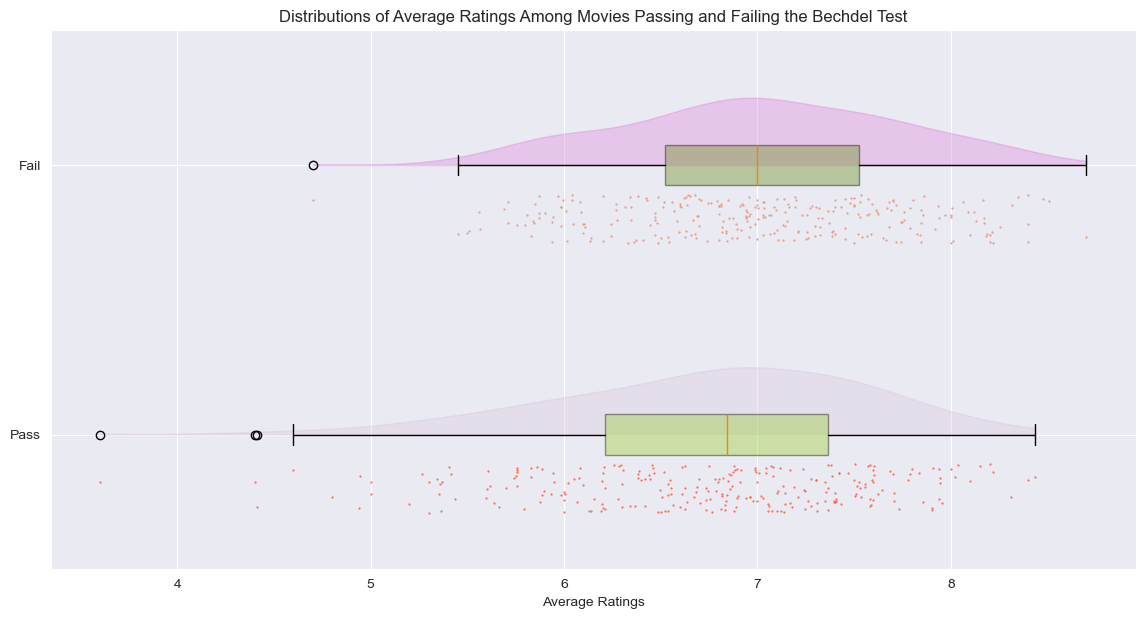

In [423]:
raincloud_plot(data, 'vote_average', column_lab='Average Rating')